# Near Miss Development: V3
- Addressing Scale of features + Uses DTW distance measure

In [14]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import time

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

PLACE_HOLDER = None

## Begin Near Miss Development Here:

#### Function IO

In [ ]:
def nearmiss_dist_v3(x, y, k):
    """
    Parameters:
    x : Long time series data (numpy array)
    y : Query sequence (numpy array)  
    k : Size of pieces, preferably a power of two (int)
    
    Returns:
    dist : Distance profile (numpy array)
    """

# Development V3 Objective:
- Implement Fast Dynamic Time Warping (DTW) into the algorithm as the distance measure instead of euclidean distance

## Proposition:
- 

#### Near Miss Shape Algorithm + DTW:
- Reimplementation of MASS V3 utilizing DTW as the distance measure

In [19]:
def nm_shape_dtw(x, y, k, r=3):
    """
    Parameters:
    x : numpy array
        Long time series data
    y : numpy array
        Query sequence
    k : int
        Size of pieces
    r : int
        Size of neighborhood when expanding the path. A higher value will
        increase the accuracy of the calculation but also increase time
        and memory consumption. A radius equal to the size of x and y will
        yield an exact dynamic time warping calculation.
    Returns:
    dist : numpy array
        DTW-based distance profile
    """
    m = len(y)
    n = len(x)
    expected_length = n - m + 1
    dist = []

    # Loop through segments of the time series x
    for j in range(0, n - m + 1, k):  # Adjust step size based on query length and window
        segment = x[j:j + m]
        
        if len(segment) == m:  # Ensure segment matches query length
            # Use DTW to compute distance between the current segment and the query
            distance, _ = fastdtw(segment, y)
            dist.append(distance)

    # Ensure consistent length
    dist = np.array(dist)
    if len(dist) > expected_length:
        dist = dist[:expected_length]
    elif len(dist) < expected_length:
        dist = np.pad(dist, (0, expected_length - len(dist)), 'constant', constant_values=np.nan)

    return dist


### Function for determining the optimal value for k (number of pieces):

In [3]:
def determine_k(n, m):
    """
    Determines the optimal value of k for MASS V3.
    
    Parameters:
    n : Length of the time series (int) 
    m : Length of the query (int)

    Returns:
    k : Optimal segment size, preferably a power of two (int)
    """
    # Set k to be the next power of two greater than or equal to 4 times the query length
    k = 2 ** int(np.ceil(np.log2(max(4 * m, m))))
    # Ensure k is not greater than the length of the time series
    k = min(k, n)
    return k

## Test Implementation

In [20]:
# Load the query and trip data (1 query and 1 trip)
x = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\x_trip_5109.csv')
y = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\y_query_7.csv')


In [21]:
# Determine the optimal segment size
n = len(x)
m = len(y)
k = determine_k(n, m)

In [22]:
# The initial columns to compare in the time series data
columns = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_jerk_mps3_analytical']

In [34]:
# Set the radius for the DTW calculation
r = 3

In [35]:
print("Test Description: This test is for Near Miss algorithm v2 implementation")

start_time = time.time()

combined_distance_profile = nm_shape_dtw(x[columns[0]].values, y[columns[0]].values, k, r)  # Initialize combined distance profile

# Loop through each column and compute the distance profile
for col in columns:
    if col == columns[0]:
        continue
    distance_profile = nm_shape_dtw(x[col].values, y[col].values, k, r)
    combined_distance_profile += distance_profile  # Sum the distance profiles

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Test Description: This test is for Near Miss algorithm v2 implementation
Time taken: 0.26567649841308594 seconds


# Analysis
- What does this new distance profile look like?

In [36]:
# Plot Distance Profile Function using seaborn
def plot_distance_profile(distance_profile):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=distance_profile)
    plt.title(f'Multivariate Distance Profile for Selected Trip', fontsize=16, fontweight='bold')
    plt.xlabel('Index', fontsize=14)
    plt.ylabel('DTW Distance', fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.show()

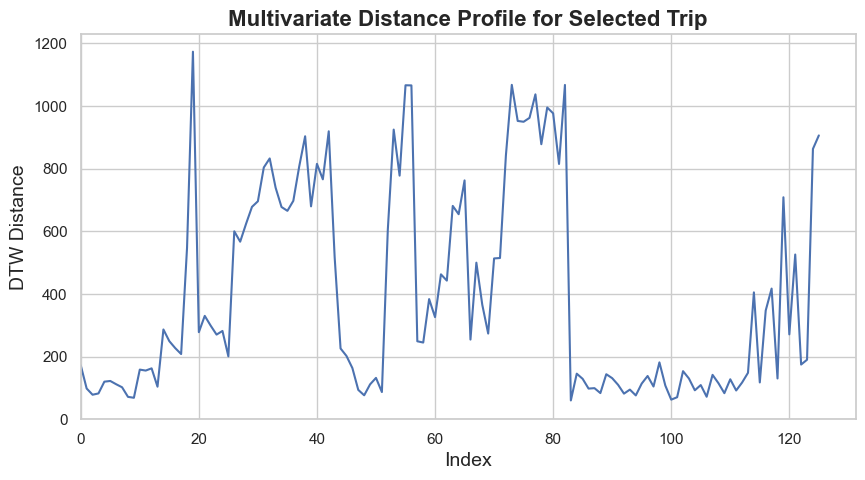

In [37]:
# Plot the combined distance profile
plot_distance_profile(combined_distance_profile)

### How do we determine the best radius for the Fast DTW method

In [15]:

def find_optimal_radius_for_query_multidim(x, y, radius_values, columns, dist=None):
    """
    Finds the optimal radius for DTW between a multi-dimensional query and a multi-dimensional time series
    by calculating the combined DTW distance for each radius across all subsequences.

    Parameters:
    ----------
    x : pandas DataFrame
        The longer time series to search through (multi-dimensional).
    y : pandas DataFrame
        The query time series (multi-dimensional).
    radius_values : list
        List of radius values to test.
    columns : list
        The list of column names representing the different dimensions.
    dist : function or int
        The method for calculating the distance between x[i] and y[j].

    Returns:
    -------
    best_radius : int
        The radius value that yields the lowest combined DTW distance.
    combined_distances : dict
        A dictionary containing the combined distances for each radius.
    """
    len_query = len(y)
    len_long_series = len(x)
    
    # Dictionary to store the combined distance for each radius
    combined_distances = {r: 0 for r in radius_values}
    
    # Loop over each subsequence of the longer time series
    for i in range(0, len_long_series - len_query + 1):
        # Initialize combined distance profile for the current subsequence
        combined_distance_profile = None
        
        # Loop through each column (dimension) and compute the DTW distance for that dimension
        for col in columns:
            subsequence = x[col].values[i:i + len_query]
            query_sequence = y[col].values
            
            # Initialize the distance profile with the first dimension
            if combined_distance_profile is None:
                combined_distance_profile = np.zeros(len(radius_values))
            
            # Calculate the DTW distance for each radius
            for idx, radius in enumerate(radius_values):
                distance, _ = fastdtw(subsequence, query_sequence, radius=radius, dist=dist)
                combined_distance_profile[idx] += distance  # Sum the distances across dimensions

        # Accumulate the combined distance profile for this subsequence
        for idx, radius in enumerate(radius_values):
            combined_distances[radius] += combined_distance_profile[idx]  # Sum the profiles across subsequences

    # Find the radius with the minimum combined distance
    best_radius = min(combined_distances, key=combined_distances.get)
    
    return best_radius, combined_distances

In [16]:
def plot_combined_distances(combined_distances):
    """
    Plots the combined DTW distances for each radius.
    
    Parameters:
    ----------
    combined_distances : dict
        A dictionary containing the combined distances for each radius.
    """
    # Extract radius values and distances for plotting
    radius_values = list(combined_distances.keys())
    distances = list(combined_distances.values())
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(radius_values, distances, marker='o', linestyle='-', color='b', label='Combined DTW Distance')
    plt.xlabel('Radius')
    plt.ylabel('Combined DTW Distance')
    plt.title('Combined DTW Distance vs. Radius')
    plt.grid(True)
    plt.legend()
    plt.show()


In [17]:
radius_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Call the function with the multi-dimensional data
best_radius, combined_distances = find_optimal_radius_for_query_multidim(x, y, radius_values, columns)

# Output the results
print(f"Best radius: {best_radius}")
print(f"Combined distances: {combined_distances}")

Best radius: 3
Combined distances: {1: np.float64(3117596.580230993), 2: np.float64(3112781.9506459977), 3: np.float64(3112743.7719809953), 4: np.float64(3112743.7719809953), 5: np.float64(3112743.7719809953), 6: np.float64(3112743.7719809953), 7: np.float64(3112743.7719809953), 8: np.float64(3112743.7719809953), 9: np.float64(3112743.7719809953), 10: np.float64(3112743.7719809953)}


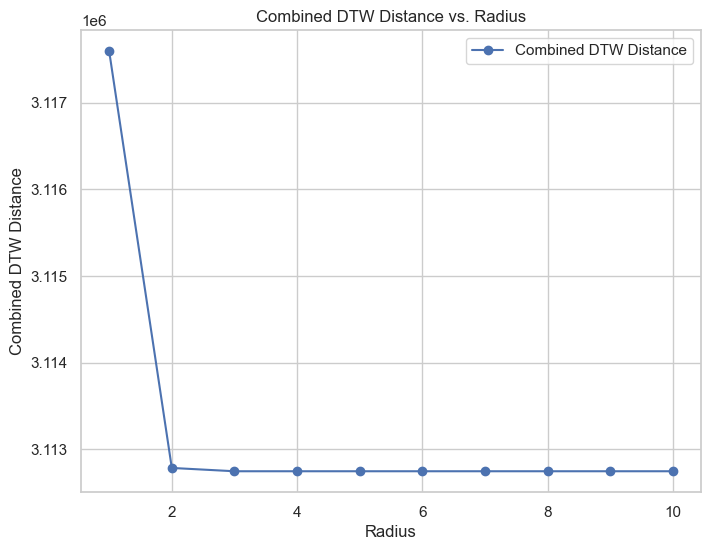

In [18]:
# Plot the results
plot_combined_distances(combined_distances)